# Optimizing Models For Predicting Forest Fires

#### The goal of this project is to predict the extent of fire damage to a forest using data from the UCI Machine Learning Repository. The dataset we're using contains information on fires, the damage caused, and associated meteorological data. With help from machine learning techniques, we are aiming to determine how specific characteristics in our dataset can be used to accurately predict future forest fire damage.

# Importing libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error

fires = pd.read_csv('fires.csv')

In [2]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


##### Categorical columns are: month, day
##### There are a significant amount of missing values in 8 of the columns
##### X is X-axis coordinate within Montesinho park map. Scale of 1-9
##### Y is Y-axis coordinate within Montesinho park map. Scale of 2-9
##### FFMC is FFMC index from FWI system: 18.7 to 96.2
##### DMC is DMC index from FWI system: 1.1 to 291.3
##### DC is from FWI system: 7.9 to 860.6
##### ISI is from FWI system: 0 to 56.1
##### temp is temperature from 2.2 to 33.3 measured in celsius
##### RH is relative humidity from 15 to 100 measured in %
##### wind is wind speed 0.4 to 9.4
##### rain is outside rain from 0 to 6.4
##### area is the target column, burned area of the forest, from 0 to 1090.84. May need log transform

# Let's explore the data

In [3]:
fires.describe()

,Unnamed: 0,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
mean,259.000000,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,149.389312,2.313778,1.229900,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,130.000000,3.000000,4.000000,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,259.000000,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,388.000000,7.000000,5.000000,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000
max,517.000000,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# Data Cleaning

It looks like we have some values that need to be converted from strings to numerical values so that we can use them in our models. We also have some columns that don't seem relevant to predicting the amount of area damaged by forest fires. We're going to start by getting rid of the columns that don't seem relevant, then converting some values from strings to numeric. Additionally, we'll also need to log transform the 'area' column, our target, because many of the values seem skewed towards 0.

In [4]:
fires = fires.drop(['Unnamed: 0', 'day'], axis=1) # don't need these columns

# convert month to an integer
month_dic = {
    'jan': '1',
    'feb': '2',
    'mar': '3',
    'apr': '4',
    'may': '5',
    'jun': '6',
    'jul': '7',
    'aug': '8',
    'sep': '9',
    'oct': '10',
    'nov': '11',
    'dec': '12'
}

for k, v in month_dic.items():
    fires['month'] = fires['month'].str.replace(k, v)

fires['month'] = fires['month'].astype(int)

fires['area'] = np.log(fires['area'] + 1) # log transform the 'area' column and add 1 to avoid taking log of 0 or negative values

In [5]:
# There are several columns with missing values, so let's impute them using KNN imputation
imputers = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

imp = KNNImputer(
    missing_values = np.nan,
    n_neighbors=3) # we have a small dataset here so I'm using 3 neighbors

imputed_fires = pd.DataFrame(imp.fit_transform(fires[imputers]), columns = imputers)

# Detecting outliers

In [6]:
# let's detect some outliers with boxplots
columnlist = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

# finding the number of outliers per column
for col in columnlist:
    quartiles = np.nanpercentile(imputed_fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5*iqr)
    upper_bound = quartiles[2] + (1.5*iqr)
    num_outliers = imputed_fires[imputed_fires[col] > upper_bound].shape[0] + imputed_fires[imputed_fires[col] < lower_bound].shape[0]
    print(f"{col} has {num_outliers} outliers.")

FFMC has 53 outliers.
DMC has 22 outliers.
DC has 25 outliers.
ISI has 23 outliers.
temp has 9 outliers.
RH has 10 outliers.
wind has 13 outliers.
rain has 8 outliers.


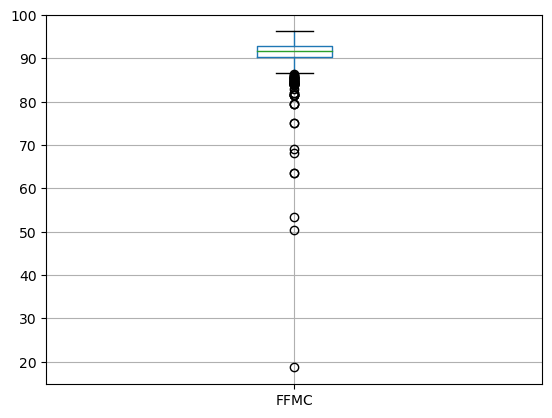

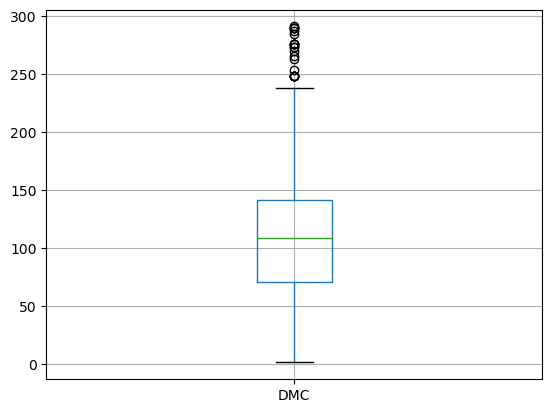

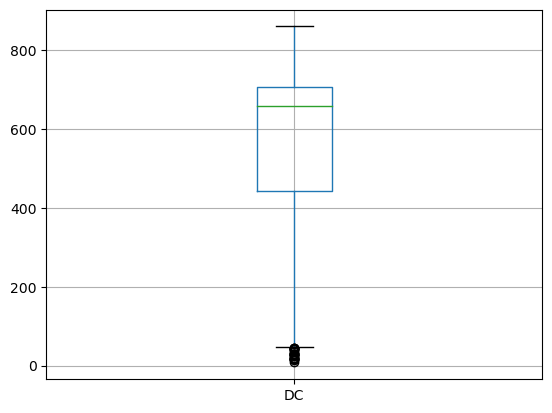

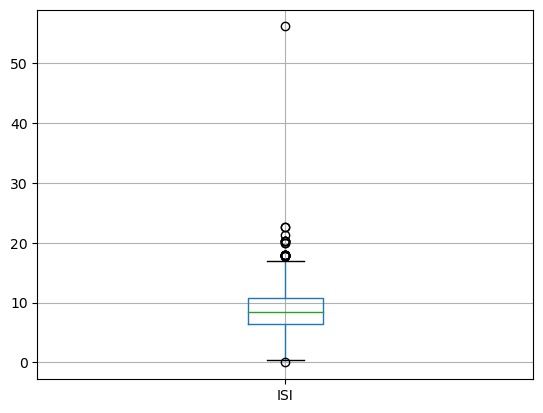

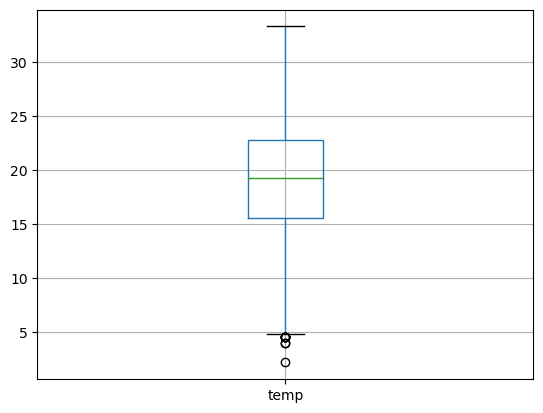

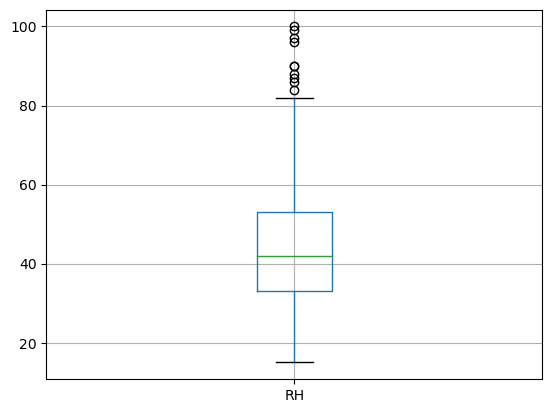

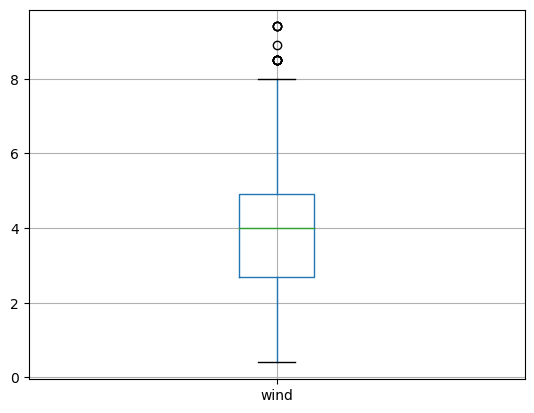

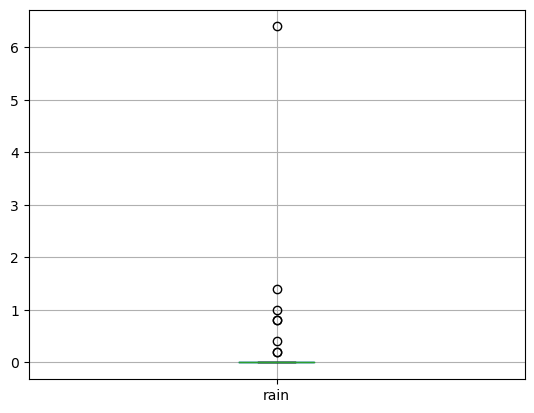

In [7]:
for col in columnlist:
    imputed_fires.boxplot(col)
    plt.show()

# Standardizing the data

In [8]:
# let's standardize some things so the features have a mean of 0 and a stddev of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

standardized_imputed_fires = scaler.fit_transform(imputed_fires) # applying the scaler to our imputed dataset
standardized_imputed_fires = pd.DataFrame(standardized_imputed_fires, columns = imputers) # create df from standardized, scaled data
non_miss_val_cols = fires.columns[~fires.columns.isin(imputers)] # get columns from 'fires' that aren't in the columns with missing values

final_fires = pd.concat([fires[non_miss_val_cols], standardized_imputed_fires], axis = 1)

# create train/test splits
X = final_fires.drop(['area'], axis=1)
y = final_fires['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Exploratory Data Analysis

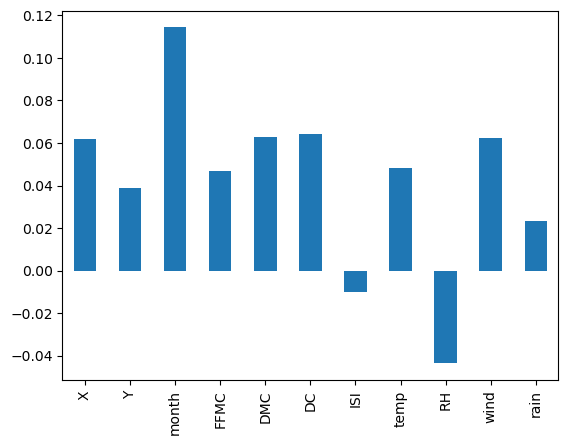

In [9]:
# let's check the correlation between area and the rest of the columns in our dataset
final_fires.corr()['area'][['X', 'Y', 'month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']].plot.bar()

plt.show() # month definitely correlates the best with our target column, but there are several others worth looking at

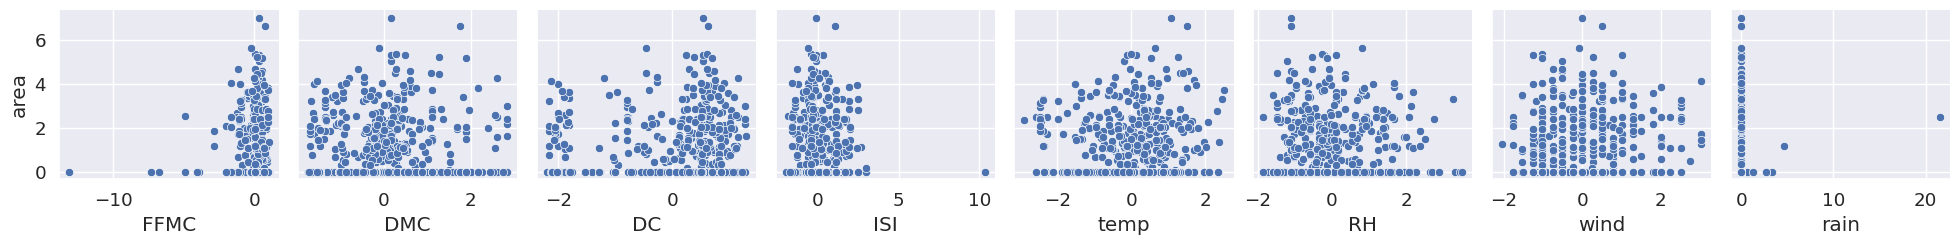

In [10]:
continuous = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

# visualizing the relationship between our continuous columns/features and the target 'area'
sns.set(font_scale=1.2)
sns.pairplot(data=final_fires, x_vars = continuous, y_vars='area')

plt.show()

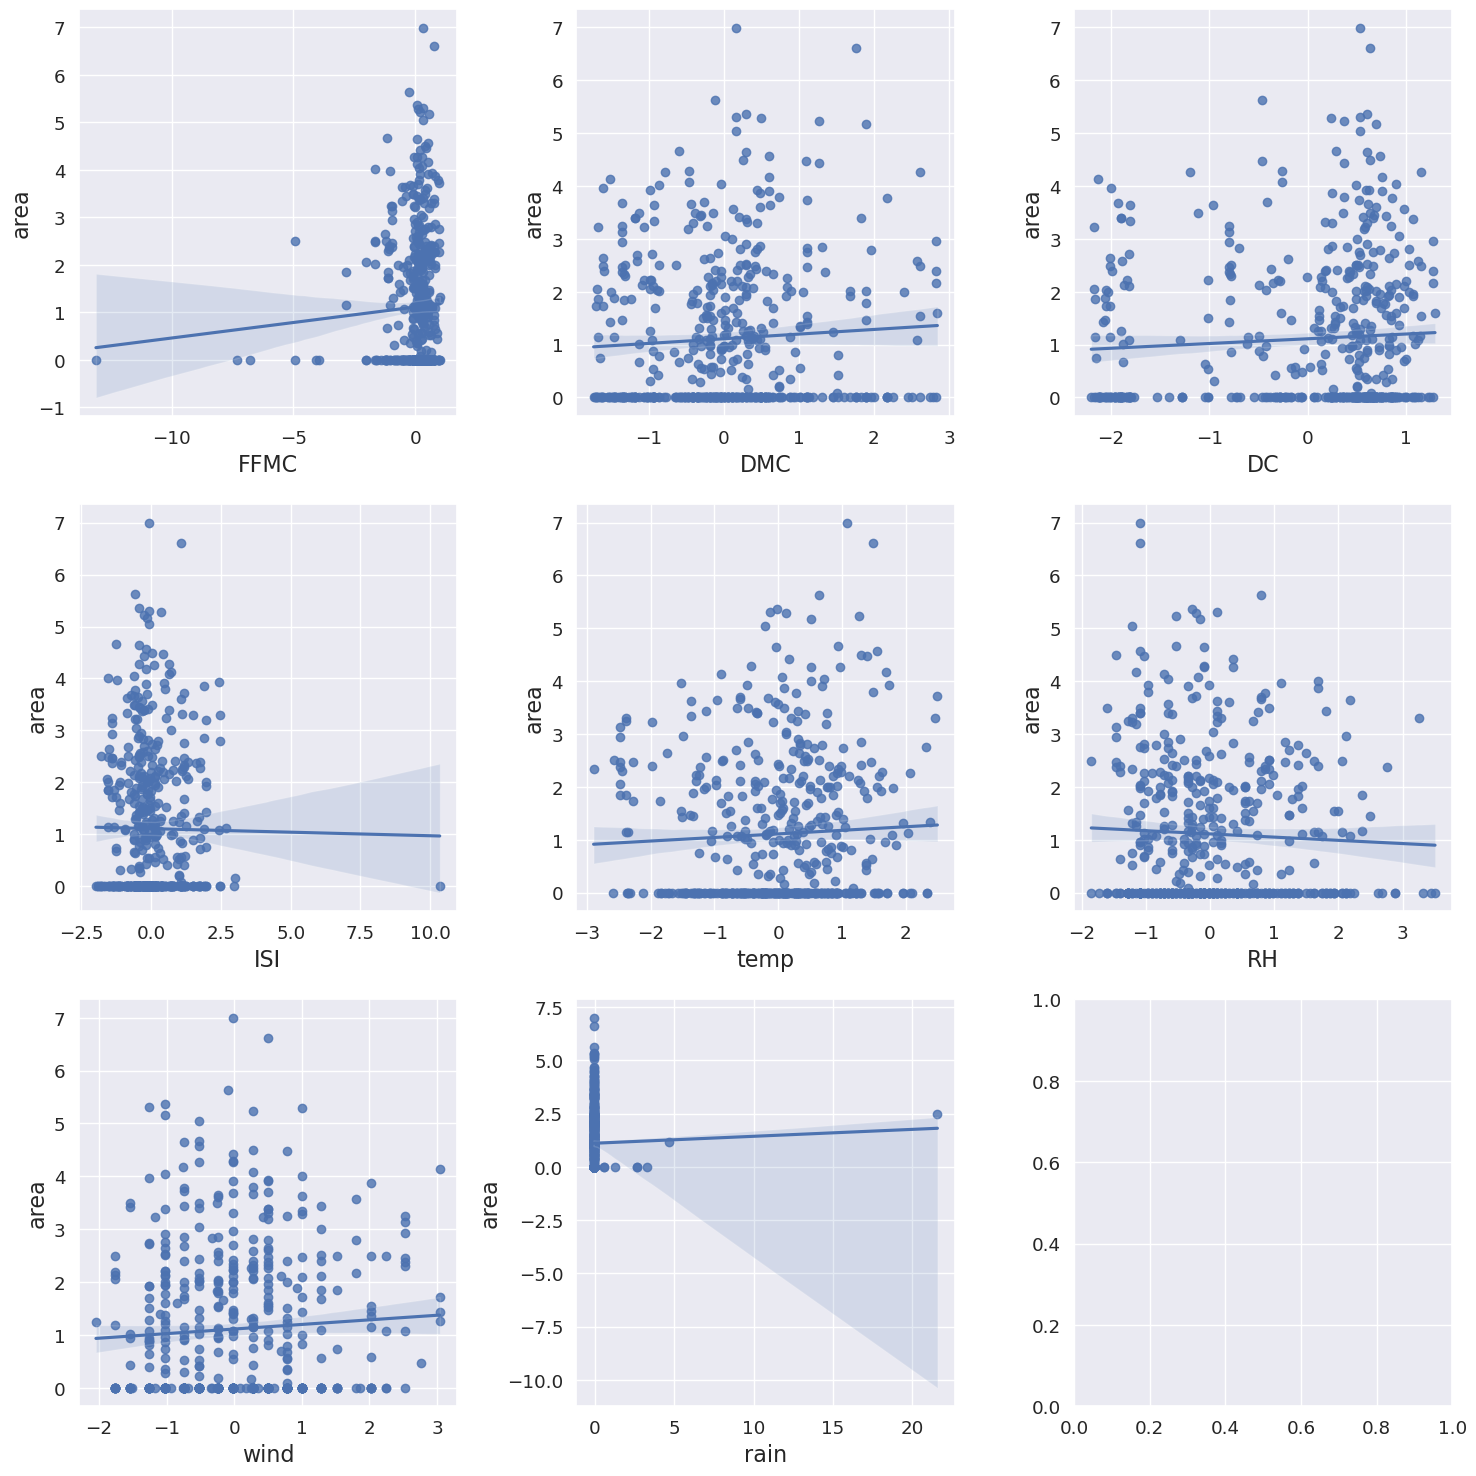

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

# create scatter plots for our features to see how they relate to 'area'
for ax, col in zip(axes.flatten(), continuous):
    sns.regplot(x=col, y='area', data=final_fires, ax=ax)
    ax.set_xlabel(col, size=16)
    ax.set_ylabel('area', size=16)
    
#for j in range(len(continuous), len(axes.flat)):
#fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

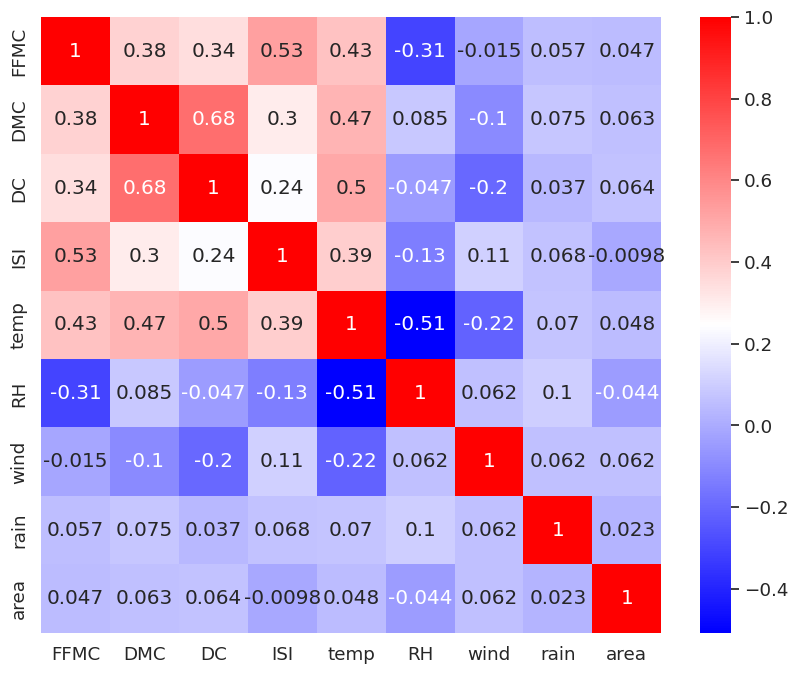

In [12]:
# let's try making a heatmap to see the correlations between our continuous variables and 'area'
continuous_2 = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

plt.figure(figsize=(10,8))
correl = final_fires[continuous_2].corr()
sns.heatmap(correl, annot=True, cmap = 'bwr')

plt.show()

The correlation coefficients show us the strength and direction of the linear relationship between pairs of variables.
* Wind, DC, and DMC seem to have the highest correlation with area, our target variable.
* There are only a couple of variables, ISI and RH, taht have a negative correlation with our target.
* This means that as ISI and humidity levels increase, the amount of burned area tends to decrease.
* Temp has a lower correlation than I would have expected, though the correlation is still positive.

# Sequential Feature Selection

Now that we've cleaned our dataset and done some initial data analysis, we can move on to selecting features for our model. I'd first like to try sequential feature selection, both forward and backward, to see what results it can come up with. This should give us an efficient way of evaluating the performance of different feature combinations and let us choose the one with the best results.

In [13]:
# going to use sequential feature selection to see which features would produce the best model if added
forward_model2 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 2,
                                          direction = 'forward')
forward_model4 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 4,
                                          direction = 'forward')
forward_model6 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 6,
                                          direction = 'forward')
forward_model8 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 8,
                                          direction = 'forward')

forward_model2.fit(X_train, y_train)
forward_model4.fit(X_train, y_train)
forward_model6.fit(X_train, y_train)
forward_model8.fit(X_train, y_train)

forward_features2 = forward_model2.get_feature_names_out()
forward_features4 = forward_model4.get_feature_names_out()
forward_features6 = forward_model6.get_feature_names_out()
forward_features8 = forward_model8.get_feature_names_out()

print(f"Forward features - 2 feature model: {forward_features2}")
print(f"Forward features - 4 feature model: {forward_features4}")
print(f"Forward features - 6 feature model: {forward_features6}")
print(f"Forward features - 8 feature model: {forward_features8}")

# Now repeating the same process but for backward feature selection
backward_model2 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 2,
                                          direction = 'backward')
backward_model4 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 4,
                                          direction = 'backward')
backward_model6 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 6,
                                          direction = 'backward')
backward_model8 = SequentialFeatureSelector(estimator = LinearRegression(),
                                          n_features_to_select = 8,
                                          direction = 'backward')

backward_model2.fit(X_train, y_train)
backward_model4.fit(X_train, y_train)
backward_model6.fit(X_train, y_train)
backward_model8.fit(X_train, y_train)

backward_features2 = backward_model2.get_feature_names_out()
backward_features4 = backward_model4.get_feature_names_out()
backward_features6 = backward_model6.get_feature_names_out()
backward_features8 = backward_model8.get_feature_names_out()

print(f"Backward features - 2 feature model: {backward_features2}")
print(f"Backward features - 4 feature model: {backward_features4}")
print(f"Backward features - 6 feature model: {backward_features6}")
print(f"Backward features - 8 feature model: {backward_features8}")

Forward features - 2 feature model: ['month' 'DC']
Forward features - 4 feature model: ['month' 'FFMC' 'DC' 'ISI']
Forward features - 6 feature model: ['Y' 'month' 'FFMC' 'DC' 'ISI' 'RH']
Forward features - 8 feature model: ['Y' 'month' 'FFMC' 'DMC' 'DC' 'ISI' 'RH' 'wind']
Backward features - 2 feature model: ['month' 'FFMC']
Backward features - 4 feature model: ['month' 'FFMC' 'DC' 'ISI']
Backward features - 6 feature model: ['Y' 'month' 'FFMC' 'DC' 'ISI' 'RH']
Backward features - 8 feature model: ['Y' 'month' 'FFMC' 'DMC' 'DC' 'ISI' 'RH' 'wind']


In [14]:
# Let's look at the common features between our forward and backward feature selection techniques
same_features2 = list(set(forward_features2) & set(backward_features2))
same_features4 = list(set(forward_features4) & set(backward_features4))
same_features6 = list(set(forward_features6) & set(backward_features6))
same_features8 = list(set(forward_features8) & set(backward_features8))

print(f"The shared features in our 2-feature model are: {same_features2}")
print(f"The shared features in our 4-feature model are: {same_features4}")
print(f"The shared features in our 6-feature model are: {same_features6}")
print(f"The shared features in our 8-feature model are: {same_features8}")

# Finally, let's fit some Linear Regression models with our selected features
forward2 = LinearRegression().fit(X_train[forward_features2], y_train)
forward4 = LinearRegression().fit(X_train[forward_features4], y_train)
forward6 = LinearRegression().fit(X_train[forward_features6], y_train)
forward8 = LinearRegression().fit(X_train[forward_features8], y_train)

backward2 = LinearRegression().fit(X_train[backward_features2], y_train)
backward4 = LinearRegression().fit(X_train[backward_features4], y_train)
backward6 = LinearRegression().fit(X_train[backward_features6], y_train)
backward8 = LinearRegression().fit(X_train[backward_features8], y_train)

The shared features in our 2-feature model are: ['month']
The shared features in our 4-feature model are: ['DC', 'FFMC', 'month', 'ISI']
The shared features in our 6-feature model are: ['DC', 'FFMC', 'month', 'Y', 'RH', 'ISI']
The shared features in our 8-feature model are: ['DC', 'wind', 'FFMC', 'month', 'Y', 'RH', 'DMC', 'ISI']


# Evaluating regularized models

We've got a pretty good idea now of what features we might want to look at later when evaluating all of our models for this project. But, these models above in our sequential feature selection are all linear models. Linear regression models don't account for non-linear components that could need to be accounted for in our data set. To address this, we'll use some regularized models like Ridge and Lasso, as well as some other flexible models like polynomials.

When we're trying other, more flexible models, we run the risk of overfitting the data by tuning the model too much on our training set so that it performs poorly on the test set. When we're experimenting with our regularized Ridge and Lasso models, we'll need to tune our parameter to make sure it isn't on the edge of the alphas argument. We also need to make sure, with Lasso specifically, that it isn't tuning all of our coefficients down to 0.

In [15]:
# messing around with Ridge and LASSO
ridge = RidgeCV(alphas = np.linspace(100, 1000, num=1000))
ridge.fit(X_train, y_train)
ridge_coef = ridge.coef_
ridge_alpha = ridge.alpha_

lasso = LassoCV(alphas = np.linspace(1, 100, num=100))
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
lasso_alpha = lasso.alpha_

y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

ridge_test_mse = mean_squared_error(y_test, y_pred_ridge)
lasso_test_mse = mean_squared_error(y_test, y_pred_lasso)

print(f"MSE with ridge is: {ridge_test_mse}.\nMSE with lasso is: {lasso_test_mse}")
print(f"ridge alpha is {ridge_alpha} and the coefficient is {ridge_coef.mean()}")
print(f"lasso alpha is {lasso_alpha} and the coefficient is {lasso_coef.mean()}")

# the lasso alpha is always on the boundary of the alphas argument, and it sets all coefficients to 0 which indicates that some of the features may not be important for predicting the target variable

MSE with ridge is: 2.284468004610033.
MSE with lasso is: 2.298768233144804
ridge alpha is 1000.0 and the coefficient is 0.00958534794405967
lasso alpha is 100.0 and the coefficient is 0.0


In [16]:
# let's try some non-linear models too
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias = False)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.transform(X_test)

linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred_lin = linear.predict(X_test)

quadratic = LinearRegression()
quadratic.fit(poly_X_train, y_train)
y_pred_quad = quadratic.predict(poly_X_test)

linear_mse = mean_squared_error(y_test, y_pred_lin)
quadratic_mse = mean_squared_error(y_test, y_pred_quad)

print(f"MSE for linear is: {linear_mse}.\nMSE for quadratic is: {quadratic_mse}")

# linear seems slightly worse than ridge or lasso in terms of MSE, but much better than quadratic

MSE for linear is: 2.2993332380563984.
MSE for quadratic is: 196241005788352.34


In [17]:
from sklearn.preprocessing import SplineTransformer

test_mses = []

for i in range(2,11):
    spline = SplineTransformer(degree = 3, n_knots = i)
    X_train_transformed = spline.fit_transform(X_train)
    X_test_transformed = spline.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_transformed, y_train)
    
    mse = mean_squared_error(y_test, lr.predict(X_test_transformed)).round(0)
    test_mses.append(mse)

# doing this gave the best MSE value with 9 knots
print(f"MSE for Splines is: {test_mses[7]}")

MSE for Splines is: 1.7877974408754506e+21


In [18]:
# let's look at K-fold cv and then compare all the MSEs using 5 folds

# K-fold CV for forward2 model
fw2_cv5 = cross_val_score(
    forward2,
    X_train[forward_features2],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for forward4 model
fw4_cv5 = cross_val_score(
    forward4,
    X_train[forward_features4],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for forward6 model
fw6_cv5 = cross_val_score(
    forward6,
    X_train[forward_features6],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for forward8 model
fw8_cv5 = cross_val_score(
    forward8,
    X_train[forward_features8],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward2 model
bw2_cv5 = cross_val_score(
    backward2,
    X_train[backward_features2],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward4 model
bw4_cv5 = cross_val_score(
    backward4,
    X_train[backward_features4],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward6 model
bw6_cv5 = cross_val_score(
    backward6,
    X_train[backward_features6],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward8 model
bw8_cv5 = cross_val_score(
    backward8,
    X_train[backward_features8],
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for Ridge model
ridge_cv5 = cross_val_score(
    ridge,
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

# K-fold CV for Lasso model
lasso_cv5 = cross_val_score(
    lasso,
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error')

results_5 = {
    'fw2': fw2_cv5,
    'fw4': fw4_cv5,
    'fw6': fw6_cv5,
    'fw8': fw8_cv5,
    'bw2': bw2_cv5,
    'bw4': bw4_cv5,
    'bw6': bw6_cv5,
    'bw8': bw8_cv5,
    'ridge': ridge_cv5,
    'lasso': lasso_cv5
}

# Now let's try the same thing but with 10 folds

# K-fold CV for forward2 model
fw2_cv10 = cross_val_score(
    forward2,
    X_train[forward_features2],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for forward4 model
fw4_cv10 = cross_val_score(
    forward4,
    X_train[forward_features4],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for forward6 model
fw6_cv10 = cross_val_score(
    forward6,
    X_train[forward_features6],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for forward8 model
fw8_cv10 = cross_val_score(
    forward8,
    X_train[forward_features8],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward2 model
bw2_cv10 = cross_val_score(
    backward2,
    X_train[backward_features2],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward4 model
bw4_cv10 = cross_val_score(
    backward4,
    X_train[backward_features4],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward6 model
bw6_cv10 = cross_val_score(
    backward6,
    X_train[backward_features6],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for backward8 model
bw8_cv10 = cross_val_score(
    backward8,
    X_train[backward_features8],
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for Ridge model
ridge_cv10 = cross_val_score(
    ridge,
    X_train,
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

# K-fold CV for Lasso model
lasso_cv10 = cross_val_score(
    lasso,
    X_train,
    y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error')

results_10 = {
    'fw2': fw2_cv10,
    'fw4': fw4_cv10,
    'fw6': fw6_cv10,
    'fw8': fw8_cv10,
    'bw2': bw2_cv10,
    'bw4': bw4_cv10,
    'bw6': bw6_cv10,
    'bw8': bw8_cv10,
    'ridge': ridge_cv10,
    'lasso': lasso_cv10
}

In [19]:
# Create a dataframe from the results of k=5 and k=10 cross-validation
results5_df = pd.DataFrame(columns=['Model', 'Avg MSE', 'STD'])
results10_df = pd.DataFrame(columns=['Model', 'Avg MSE', 'STD'])

for model, mse in results_5.items():
    model_df = pd.DataFrame({'Model': [model], 'Avg MSE': [mse.mean()], 'STD': [mse.std()]})
    results5_df = pd.concat([results5_df, model_df], ignore_index=True)
    
for model, mse in results_10.items():
    model_df = pd.DataFrame({'Model': [model], 'Avg MSE': [mse.mean()], 'STD': [mse.std()]})
    results10_df = pd.concat([results10_df, model_df], ignore_index=True)
    
print(results5_df)
print(results10_df)

   Model   Avg MSE       STD
0    fw2 -1.858202  0.374073
1    fw4 -1.854943  0.369593
2    fw6 -1.856787  0.365762
3    fw8 -1.867784  0.358876
4    bw2 -1.860696  0.379132
5    bw4 -1.854943  0.369593
6    bw6 -1.856787  0.365762
7    bw8 -1.867784  0.358876
8  ridge -1.911568  0.350981
9  lasso -1.889979  0.357108
   Model   Avg MSE       STD
0    fw2 -1.848421  0.483248
1    fw4 -1.857314  0.483882
2    fw6 -1.866386  0.476995
3    fw8  -1.86687  0.484122
4    bw2 -1.859264  0.487651
5    bw4 -1.857314  0.483882
6    bw6 -1.866386  0.476995
7    bw8  -1.86687  0.484122
8  ridge -1.867466  0.474885
9  lasso -1.881145  0.471205


* Based on our results tables above, the best performing model seems to be the forward2 or backward2
* Since they both appear to offer the same average MSE and STD, I'm just going to pick the forward2 model for examination

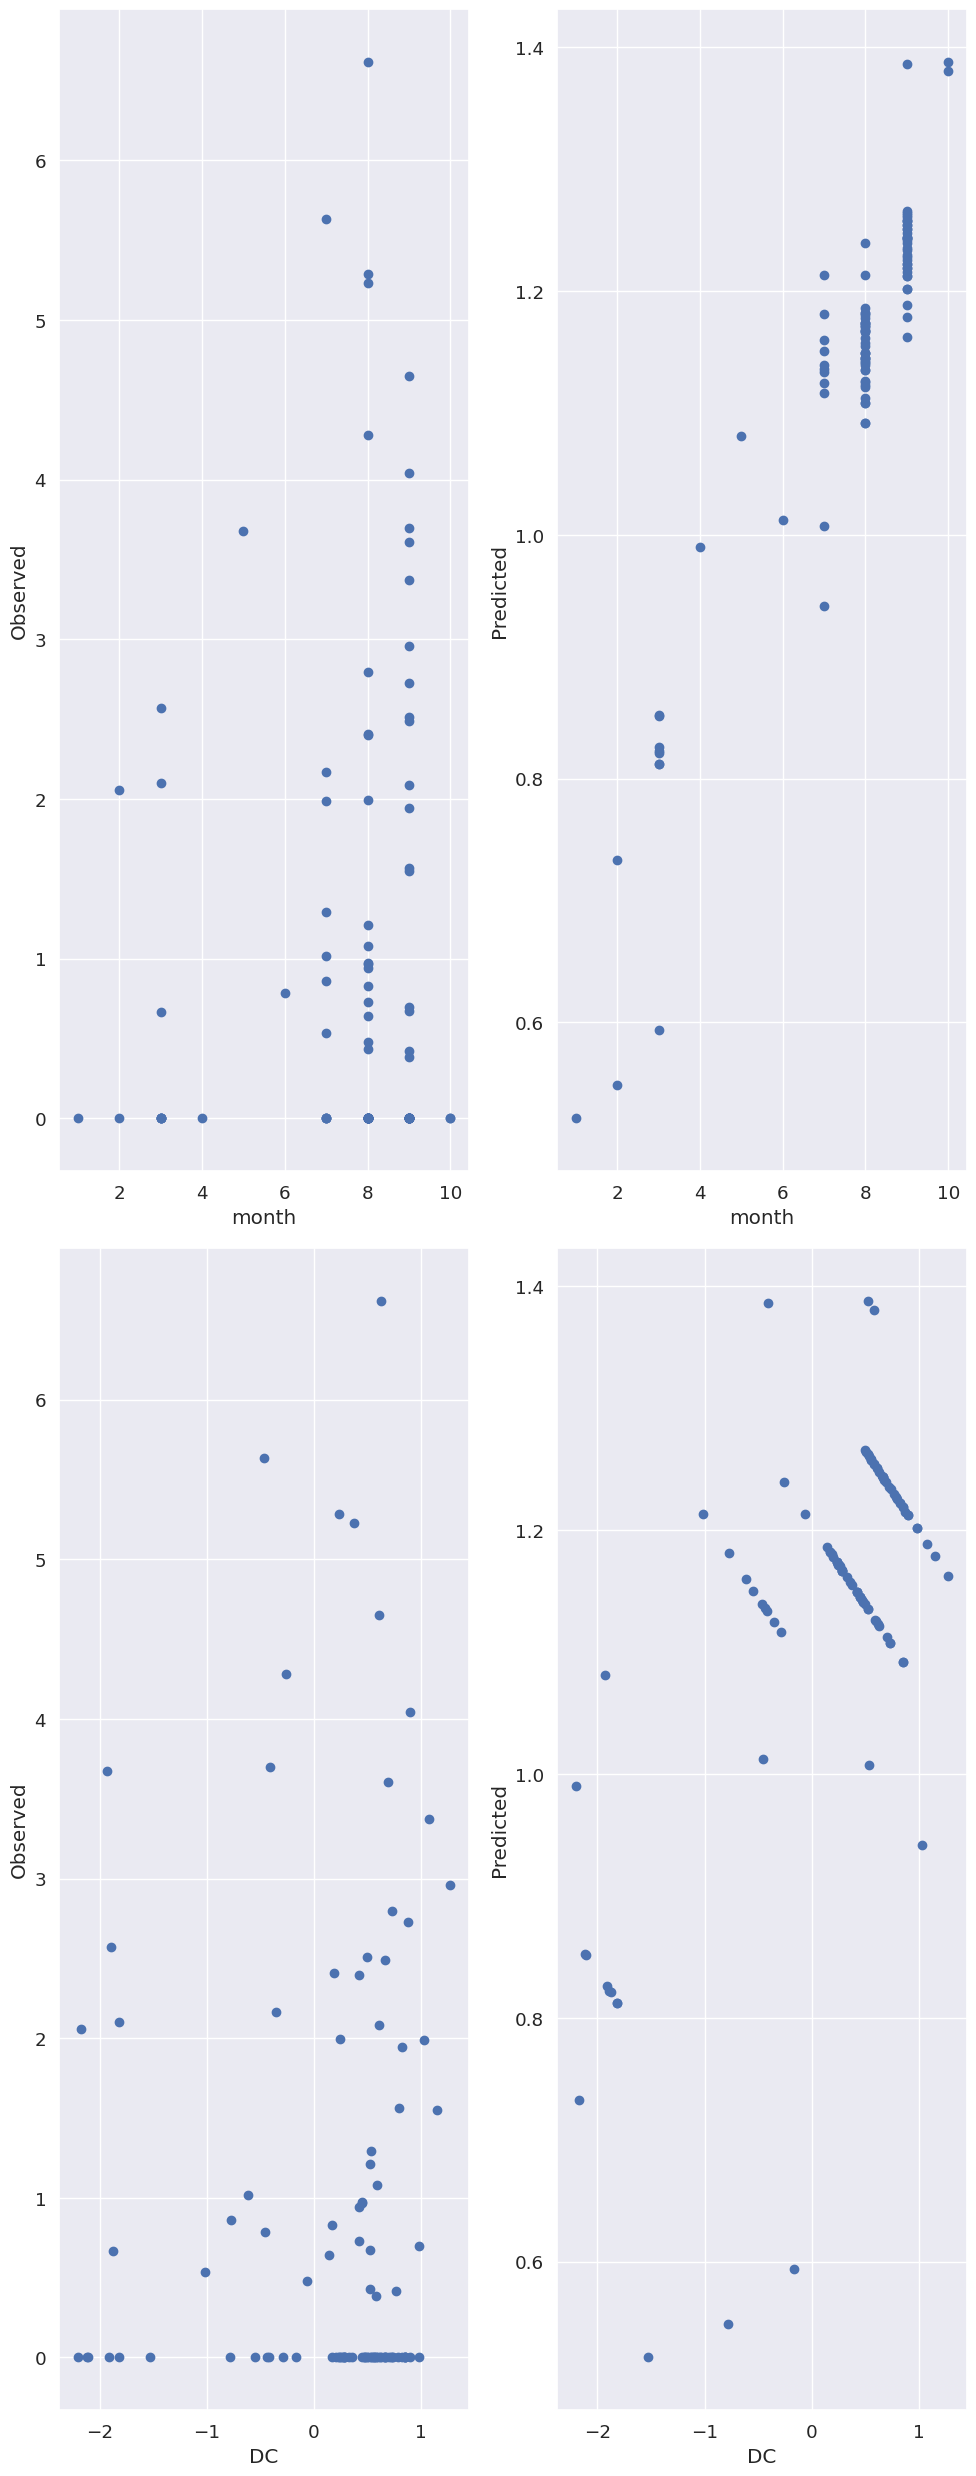

In [20]:
# Making predictions on the test data
y_pred = forward2.predict(X_test[forward_features2])

# Find the residuals
residuals = y_test - y_pred

# Plot observed/predicted values and the residuals for each
figs, axs = plt.subplots(nrows=len(forward_features2), ncols=2, figsize=(10,25))

for i, feature in enumerate(forward_features2):
    axs[i, 0].scatter(X_test[feature], y_test)
    axs[i, 0].set_xlabel(feature)
    axs[i, 0].set_ylabel('Observed')
    
    axs[i, 1].scatter(X_test[feature], y_pred)
    axs[i, 1].set_xlabel(feature)
    axs[i, 1].set_ylabel('Predicted')
    
plt.tight_layout()
plt.show()

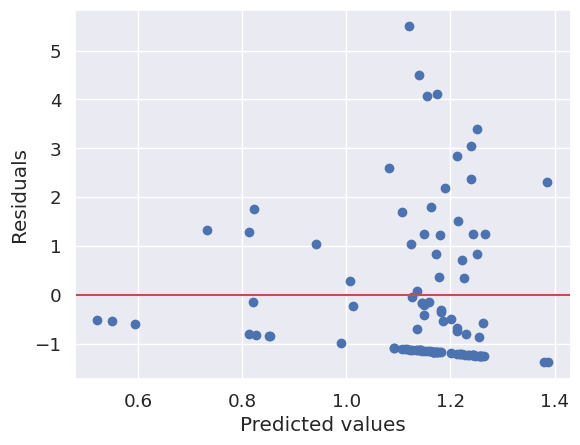

In [21]:
# Plotting the residuals as a function of the predicted values
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

plt.show()

# Conclusion

Most of the data points seem scattered around the 0 line (for perfect predictions). This suggests that the linear regression model we used is a good fit for our data set. Looking at where the points are scattered, it looks like our model isn't making predictions that are consistently too high or low.

With this project, we demonstrated the use of many different techniques in our machine learning library and used these techniques to build models that could accurately predict the outcomes based on our provided data. We used imputation to fill in missing data from our data set, looked at outliers and examined the correlation between our feature columns and our target column. We also built several regularized and non-linear models and used k-fold cross validation to evaluate our models.

This project was very helpful because it allowed us to gain important insights into the process of building and refining machine learning models. We got to experiment with several different techniques and used a healthy amount of skills and knowledge regarding machine learning with Python. In the end, we created a successful model that performs well and can be further optimized to improve its accuracy.